<a href="https://colab.research.google.com/github/santos-luciano/survival_ibovespa/blob/main/An%C3%A1lise_do_tempo_de_recupera%C3%A7%C3%A3o_do_IBOVESPA_de_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install lifelines

In [ ]:
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from lifelines.plotting import plot_lifetimes

Em março de 2020, a B3 (bolsa de valores oficial do Brasil), acionou o seu mecanismo de defesa um total de 6 vezes, o *circuit breaker*. Essa ferramente é acionada em momentos de bastante variação do índice, comportamento comum em crises. A crise atrelada a este momento, se diz respeito ao aumento do número de casos de covid no mundo.

# Analisando o IBOVESPA no ano 2020

In [ ]:
ibovespa = yf.download('^BVSP',start = '2020-01-01',end = '2020-12-31')['Close']

[*********************100%***********************]  1 of 1 completed


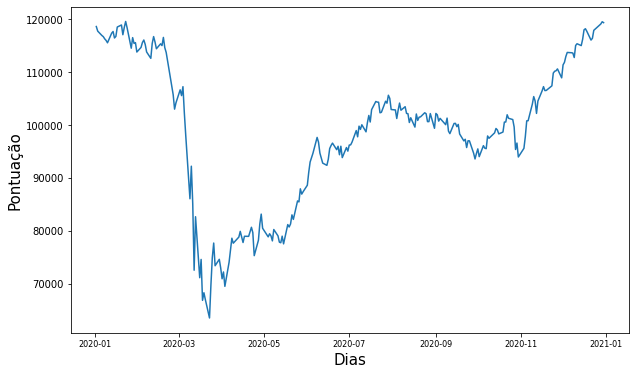

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(ibovespa)
plt.xlabel('Dias',fontsize = 15)
plt.ylabel('Pontuação',fontsize = 15)
plt.xticks(fontsize = 8)
plt.show()

Na figura acima, é possível observar a evolução do IBOVESPA ao longo de 2020. O índice tem uma queda acentuada no mês de março até chegar o sua pontuação mínima no ano, para assim iniciar sua recuperação.

In [ ]:
variacao = [0]
for dia in range(1,len(ibovespa)):
  variacao.append(ibovespa[dia]/ibovespa[dia-1]-1)
ibovespa_variacao = pd.DataFrame(variacao,columns = ['var'])
ibovespa_variacao.index = ibovespa.index

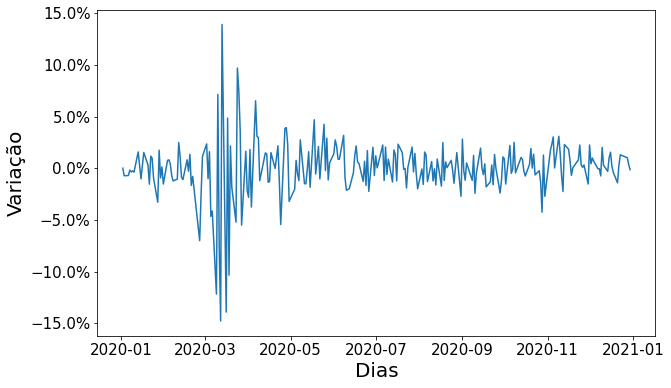

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(ibovespa_variacao['var'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xlabel('Dias',fontsize = 20)
plt.ylabel('Variação',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

Na Figura acima é mostrada a variação diária do IBOVESPA no ano de 2020, é possível observar que atingiu variações acima de 10%

Na seção abaixo, será explorado o comportamento das ações que integravam o índice no momento da crise

# Leitura do arquivo com as ações que integravam o IBOVESPA no 1º quadrimestre de 2020

O primeiro acionamento do *circuit breaker* aconteceu no dia 9 de março (segunda-feira), ou seja, foi observado uma variação de +10% na pontuação comporada com o último dia de negociação que foi 6 de março (sexta-feira).

Será analisada o tempo de recuperação das ações com o marco inicial o último dia antes do acionamento do mecanismo de defesa, o dia 06 de março de 2020.

In [ ]:
acoes_ibovespa = pd.read_excel('/content/drive/MyDrive/PRV_GMCT.XLSX',skiprows=1 ).iloc[:73]
cod_acoes = acoes_ibovespa['COD.'].values+'.SA'
cotacoes_acoes = yf.download(cod_acoes.tolist(),start = '2020-03-06',end = '2020-12-31')['Close']

In [ ]:
cotacoes_acoes_ibo = cotacoes_acoes.reset_index()
#cotacoes_acoes_ibo.reset_index(inplace = True)
primeira_recuperacao = []
falha = []
for cod in cod_acoes.tolist():
  col_acao = cotacoes_acoes_ibo[cod]
  if col_acao.isnull().sum()!=204:
    recuperacoes = col_acao[col_acao>=col_acao[0]]
    try:
      primeira_recuperacao.append(recuperacoes.index[1])
      falha.append(1)
    except:
      primeira_recuperacao.append(203)
      falha.append(0)
  else:
    primeira_recuperacao.append(None)
    falha.append(None)

In [ ]:
dados_sobrevivencia = pd.DataFrame([acoes_ibovespa['COD.'].values,primeira_recuperacao,falha],index = ['cod_acoes','dias','falha']).T
dados_sobrevivencia = dados_sobrevivencia.set_index('cod_acoes')
dados_sobrevivencia_completo = dados_sobrevivencia.dropna(subset = ['dias'])

/usr/local/lib/python3.8/dist-packages/lifelines/plotting.py:727: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


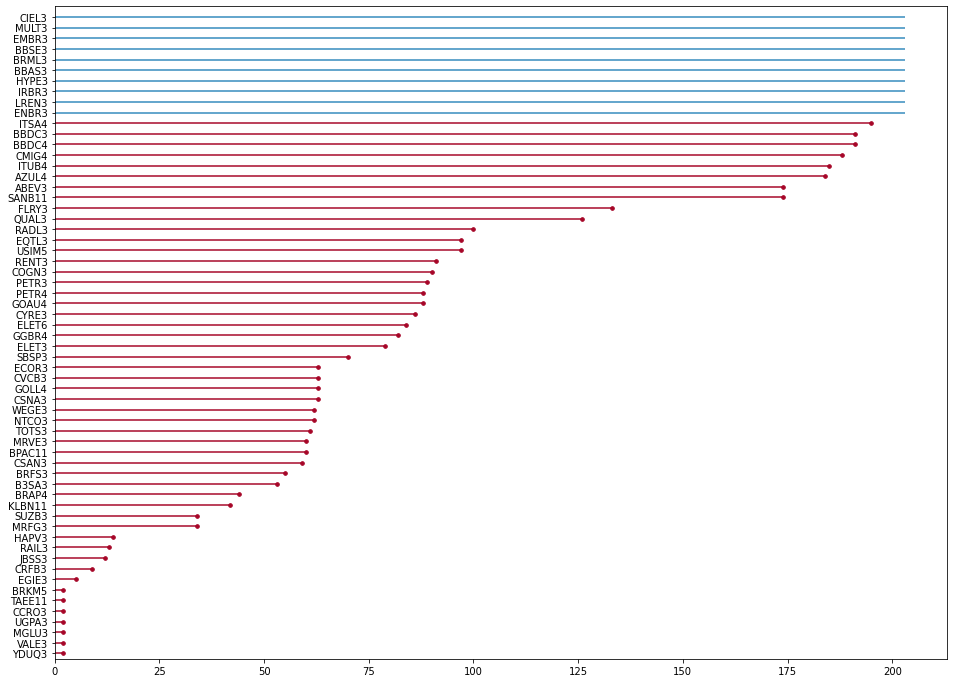

In [ ]:
plt.figure(figsize = (16,12))
ax = plot_lifetimes(dados_sobrevivencia_completo.dias.astype('float'),dados_sobrevivencia_completo.falha.astype('float'))

A figura acima mostra quantos dias de negociações na B3, foram necessários para a ação retomar a cotação do dia 06 de março de 2020. As ações com linha da cor azul, são ações que não conseguiram atingir a sua 1ª recuperação no ano de 2020.

#Estimando a curva de sobrevivência para o IBOVESPA

In [ ]:
from lifelines import(KaplanMeierFitter,WeibullFitter,ExponentialFitter,LogNormalFitter
                       ,PiecewiseExponentialFitter)

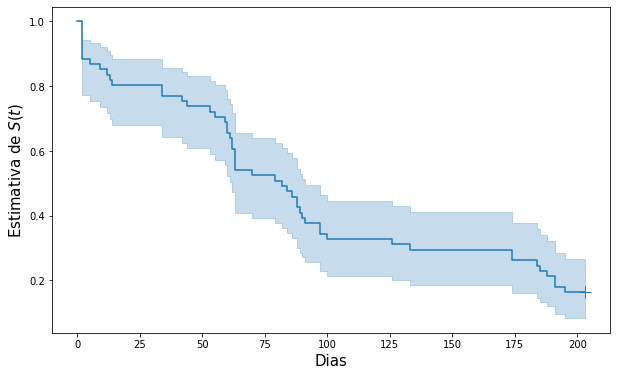

In [ ]:
kmf = KaplanMeierFitter()
T = dados_sobrevivencia_completo["dias"].astype('float')
E = dados_sobrevivencia_completo["falha"].astype('float')

#kaplan meier
plt.figure(figsize = (10,6))
kmf.fit(T, event_observed=E)
kmf.plot_survival_function(show_censors = True,ci_show=True,legend = False)
plt.xlabel('Dias',fontsize = 15)
plt.ylabel('Estimativa de $S(t)$',fontsize = 15)
plt.show()

Cada degrau da Figura representa que uma ação atingiu a sua 1ª recuperação

In [ ]:
print(kmf.median_survival_time_)

82.0


A mediana é de 81 dias, ou seja, 50% das ações conseguiram atingir a sua 1ª recuperação em até 81 dias de negociações na B3

Na busca de encontrar um modelo descreva da melhor forma o tempo da 1ª recuperação da ações que integravam o IBOVESPA no 1º quadrimestre de 2020, será estimado a $S(t)$ dos principais modelos paramétricos

In [ ]:
# modelos parametricos

wbf = WeibullFitter()
exf = ExponentialFitter()
lnf = LogNormalFitter()

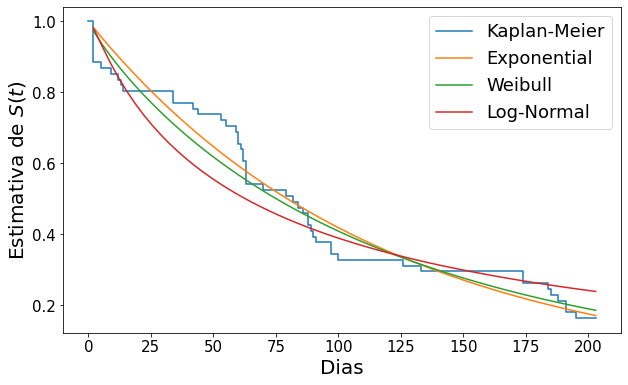

In [ ]:
plt.figure(figsize = (10,6))
kmf.fit(T, event_observed=E, label="Kaplan-Meier")
kmf.plot_survival_function(show_censors = False,ci_show=False)

exf.fit(T, event_observed=E, label="Exponential")
exf.plot_survival_function(show_censors = False,ci_show = False)

wbf.fit(T, event_observed=E, label="Weibull")
wbf.plot_survival_function(show_censors = False,ci_show = False)

lnf.fit(T, event_observed=E, label="Log-Normal")
lnf.plot_survival_function(show_censors = False,ci_show = False)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Dias',fontsize = 20)
plt.ylabel('Estimativa de $S(t)$',fontsize = 20)
plt.legend(fontsize = 18)
plt.show()

Os modelos paramétricos mais usuais não obtiveram resultados satisfátorios para o estudo, sendo necessário a utilização de modelos alternativos.

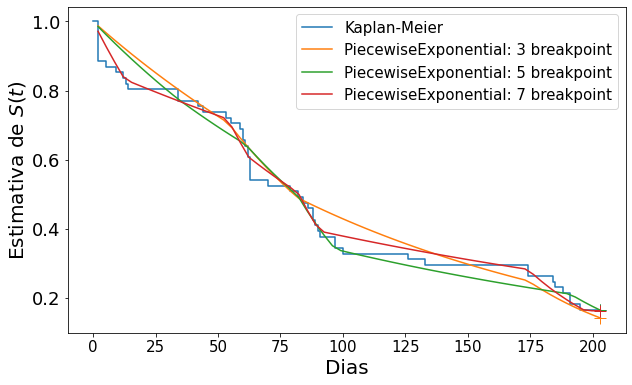

In [ ]:
plt.figure(figsize = (10,6))

import numpy as np

kmf.fit(T, event_observed=E,label = 'Kaplan-Meier')
kmf.plot_survival_function(show_censors = True,ci_show=False)

aic = []
for i in range(3,9,2):
    knots2 = np.percentile(T, 100 * np.linspace(0.05, 0.95, 2+i))
    pef = PiecewiseExponentialFitter(knots2[1:-1], label="PiecewiseExponential: {} breakpoint".format(i))
    pef.fit(T, event_observed=E)
    pef.plot_survival_function(show_censors = True,ci_show = False)
#    print(pef.print_summary())
    plt.legend(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 18)
    plt.xlabel('Dias',fontsize = 20)
    plt.ylabel('Estimativa de $S(t)$',fontsize = 20)
    aic.append(pef.AIC_)


Os modelos PiecewiseExponential apresentaram graficamente uma aderencia maior ao Kaplan-Meier

In [ ]:
aics = [exf.AIC_,wbf.AIC_,lnf.AIC_,aic[0],aic[1],aic[2]]
name_modelos = ['Exponencial','Weibull','Log-Normal','PiecewiseExponential - 3','PiecewiseExponential - 5','PiecewiseExponential - 7']
AIC = pd.DataFrame([name_modelos,aics],index = ['models','aic']).T


Na tabela abaixo é possivel observar a comparação da métrica AIC, que serve para comparação entre os modelos em que quanto menor, melhor o modelo será entre os comparados.

In [ ]:
AIC

,models,aic
0,Exponencial,587.843852
1,Weibull,588.964326
2,Log-Normal,598.726646
3,PiecewiseExponential - 3,586.328633
4,PiecewiseExponential - 5,585.521936
5,PiecewiseExponential - 7,570.129173


Os modelos Piecewise Exponential apresentaram um ajuste mais satisfatório quanto aos modelos paramétricos mais usuais. Podemos observar que quanto mais *breaks* adicionadas ao o Pieccewise o AIC diminui. É desejado o modelo com menos AIC, porém deve haver cuidados, pois quanto mais *breaks* terá mais parametros para serem estimados, além do modelo poder cair no problema do *overfitting*.